In [1]:
import pandas as pd
import numpy as np
import cvxpy as cp
import mosek
import pickle
from pandas.tseries.offsets import BMonthEnd
from time import time
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from PerformanceMetrics import *

import seaborn as sns

In [2]:
ff_factors = pd.read_csv('data/F-F_Research_Data_Factors_Monthly.csv',index_col=0)
ff_factors.index = pd.to_datetime(ff_factors.index)

ff_factors = ff_factors.reset_index()
cols = list(ff_factors.columns)
cols[0]='Date'
ff_factors.columns = cols

ff_factors.tail(5)

,Date,Mkt-RF,SMB,HML,RF
1150,2022-05-31,-0.0034,-0.0185,0.0841,0.0003
1151,2022-06-30,-0.0843,0.0209,-0.0597,0.0006
1152,2022-07-29,0.0957,0.0281,-0.0410,0.0008
1153,2022-08-31,-0.0378,0.0139,0.0031,0.0019
1154,2022-09-30,-0.0936,-0.0081,0.0005,0.0019


In [3]:
n = 2000

# Get the excess returns data
idx = pd.read_csv('data/TOP{}_universe.csv'.format(n), parse_dates=[0])
idx = idx[idx['date'] >= '1970-01-01'].reset_index(drop = True)

returndata = pd.read_csv('data/crspmsf.csv', index_col = 0)[['date', 'permno', 'ret']]
returndata['date'] = pd.to_datetime( returndata['date'] )
returndata['permno'] = returndata['permno'].astype(int)
returndata = returndata[returndata['date'] >= '1970-01-01'].reset_index(drop = True)
returndata['date'] = pd.to_datetime(returndata['date']) - pd.tseries.offsets.MonthBegin() + pd.tseries.offsets.BMonthEnd()

betaData = pd.read_csv('data/return_pf_excess_ret_beta.csv', index_col = 0)[['date','permno' ,'beta_30']]
betaData['date'] = pd.to_datetime(betaData['date'],format='%Y%m') + BMonthEnd()
betaData = betaData[betaData['date'] >= '1970-01-01'].reset_index(drop = True)


with open('data/exalpha_beta_30.pkl', 'rb') as f:
    data = pickle.load(f)

print(idx.head())
print(data.head())
print(returndata.head())

universe = pd.read_csv(f'data/TOP2000_universe.csv',parse_dates=[0],index_col=0)
universe500 = pd.read_csv(f'data/TOP500_universe.csv',parse_dates=[0],index_col=0)
ff_loadings = pd.read_pickle('data/ffloadings_halflife36_TOP2000.pkl')
ff_cov_df = pd.read_pickle(f'data/ff_cov_halflife{36}.pkl')
spec_est = pd.read_pickle(f'data/spec_est_halflife{36}_TOP{2000}.pkl')

def risk_cov(date):
    ff_cols = ['Mkt-RF','HML','SMB']
    betas = ff_loadings.loc[date,(universe.loc[date],slice(None))].unstack()[ff_cols].dropna(axis=0)
    ff_cov = ff_cov_df.loc[date].loc[ff_cols,ff_cols]
    spec_cov = spec_est.loc[date]
    
    idx = spec_cov.index.intersection(betas.index)
    spec_cov = spec_cov.reindex(idx)
    betas = betas.reindex(idx)

    cov = betas@ff_cov@betas.T + np.diag(spec_cov)
    return cov

        date      0      1      2      3      4      5      6      7      8  \
0 1970-01-30  12490  10401  12079  11754  11850  14322  27983  14736  12060   
1 1970-02-27  12490  10401  12079  11754  11850  14322  14736  27983  12060   
2 1970-03-31  12490  10401  12079  11850  11754  14322  14736  27983  12060   
3 1970-04-30  12490  10401  12079  11850  11754  14322  14736  27983  12060   
4 1970-05-29  12490  10401  12079  11850  11754  14322  14736  27983  12060   

   ...   1990   1991   1992   1993   1994   1995   1996   1997   1998   1999  
0  ...  48661  31480  41304  40256  48573  48899  45460  35246  44177  37444  
1  ...  43174  46711  34331  49998  35051  41304  43406  46519  45823  38340  
2  ...  33582  46500  35641  49429  37612  36644  36695  33830  44943  41574  
3  ...  47618  31106  46498  44804  32459  47407  31819  41574  37989  47685  
4  ...  31595  32440  31106  14197  42876  44513  32133  39132  48848  43537  

[5 rows x 2001 columns]
date        permno
1970-01

In [4]:
def FactorMimickingPortOpt_MV(alpha, beta, gamma, V):
    '''
    output the optimal weights for the factor mimicking portfolio
    - only constraint is beta neutral 
    '''
    n = V.shape[0]
    x = cp.Variable(n)
    
    obj = cp.Maximize(x.T@alpha - gamma/2*cp.quad_form(x,V))
    constraints = [x.T@beta == 0]
    prob = cp.Problem(obj, constraints)
    prob.solve(solver=cp.GUROBI)
    return x.value, prob.value

def FactorMimickingPortOpt_SR(alpha, beta, V, indiv_alpha_contrib=0.1):
    '''
    output the optimal weights for the factor mimicking portfolio
    - only constraint is beta neutral 
    '''

    # try:

    n = V.shape[0]
    z = cp.Variable(n)
    kappa = cp.Variable(1)

    alpha = alpha.reshape(alpha.shape[0])
    V = cp.atoms.affine.wraps.psd_wrap(V)

    obj = cp.Minimize(cp.quad_form(z,V))

    # ORIGINAL CONSTRAINT: SUM(X)==1 CONSTRAINT IS NOT APPLICABLE
    # constraints = [z.T@beta == 0, z.T@alpha == 1, np.ones(n)@z-kappa==0, kappa>=0, ]
    # FIRST UPDATED CONSTRAINT: WORKS BUT CAN LEAD TO CONCENTRATED PORTFOLIOS
    # constraints = [z.T@beta == 0, z.T@alpha == 1 ]
    # NEW UPDATED CONSTRAINT: LIMIT EACH POSITION'S ALPHA CONTRIBUTION TO A CONSTANT VALUE
    constraints = [z.T@beta == 0, z.T@alpha == 1, cp.multiply(z,alpha) <= indiv_alpha_contrib]
    prob = cp.Problem(obj, constraints)
    val = prob.solve(solver=None,verbose=False)
    if z.value is None:
        raise Exception()
    #return z.value/ kappa.value 
    return z.value


In [5]:
targetVol = 0.05
fullData = dict()
noConv = 0
#for i in range(1, idx['date'].shape[0]):
#for i in tqdm(list(range(36,120))):
for i in tqdm(list(range(36, idx.shape[0] - 1))):
    start = time()

    #Loop through the dates
    specificDate = idx['date'][i]
    returnsDate = idx['date'][i+1]

    #Get the covariance matrix
    V = risk_cov(specificDate)

    #For that specific date, get the permno of the investable stocks 
    specificPermno = idx[idx['date'] == specificDate].iloc[:, 1:].T
    specificPermno.columns = ['permno']

    #Get the alphas for that specific date
    alphas = pd.DataFrame( data[specificDate]).reset_index()
    alphas['beta_30_exalpha'] = (alphas['beta_30_exalpha'] - alphas['beta_30_exalpha'].mean())/alphas['beta_30_exalpha'].std()

    #Get the betas for that specific date
    betas = betaData[betaData['date'] == specificDate]

    #merge the alphas of that date with the permno of the investable stocks
    alphas_permno = pd.merge(alphas, specificPermno, how = 'inner', on = 'permno')

    #merge the betas of that date with the permno of the investable stocks
    betas_permno = pd.merge(betas, specificPermno, how = 'inner', on = 'permno')

    #Merge the returns of that date with the permno of the investable stocks
    returns_permno = pd.merge(returndata[returndata['date'] == returnsDate].dropna(), specificPermno, how = 'inner', on = 'permno')

    #Merge, alphas, betas and returns 
    investableStocks = pd.merge(alphas_permno, betas_permno, on = 'permno', how = 'inner')
    investableStocks = pd.merge(investableStocks, returns_permno, on = 'permno', how = 'inner')
    investableStocks = pd.merge(investableStocks, universe500.loc[specificDate].rename('permno').to_frame(), on = 'permno', how = 'inner')
    investableStocks,V = investableStocks.set_index('permno').align(V,join='inner',axis=0)
    

    V = V.reindex(columns=V.index)

    # #the shape of investable stocks is not matching with the shape of V.
    # finalPermno = ''
    # if V.shape[0] < investableStocks.shape[0]:
    #     print('V smaller')
    #     finalPermno = list( V.index)
    #     invest_copy = investableStocks.set_index('permno')
    #     investableStocks = invest_copy.loc[finalPermno, :]
    # else:
    #     finalPermno = list( investableStocks.permno)
    #     V = V.loc[finalPermno, finalPermno]

    assert investableStocks.isna().sum().sum() == 0
    assert V.shape[0] == investableStocks.shape[0], 'Shape of alphas and V must match'

    shape = (investableStocks.shape[0], 1)
    alpha = investableStocks['beta_30_exalpha'].values.reshape(shape)
    beta = investableStocks['beta_30'].values.reshape(shape)
    V_np = V.values

    try:
        w = FactorMimickingPortOpt_SR(alpha, beta, V_np)
        print('sum of weights', w.sum())
        portfolioVol = np.sqrt(w.T @ V @ w)
        scaledW = (targetVol/portfolioVol) * w
        investableStocks['w'] = w
        investableStocks['scaled_w'] = scaledW
        
        #Create one column with equally weighted weights and equally weighted weights scaled
        
        #Sort values
        investableStocks = investableStocks.sort_values(by = 'beta_30')

        #get top and bottom percentiles
        perc10 = investableStocks.shape[0]//10
        perc90 = investableStocks.shape[0] - perc10

        #Define the weight of top and bottom 10%
        investableStocks['wEq'] = 0
        investableStocks.iloc[0:perc10, -1] = (1/perc10)
        investableStocks.iloc[perc90:, -1] = 1/(investableStocks.shape[0] - perc90)

        #Define winner and losser and get the betas
        winner = investableStocks.iloc[0:perc10, :]
        losser = investableStocks.iloc[perc90:, :]

        betaWinner = winner.beta_30.T @  winner.wEq
        betaLosser = losser.beta_30.T @  losser.wEq

        #Fix a proportion of the loser portfolio and find the proportion of the winner
        propLosser = -0.5
        propWinner = -(propLosser * betaLosser)/betaWinner

        #Multiply the weights by those proportions
        investableStocks.iloc[0:perc10, -1] *= propWinner
        investableStocks.iloc[perc90:, -1] *= propLosser
        
        #Scale to target vol
        investableStocks['wEqScaled'] = (targetVol/portfolioVol) * investableStocks['wEq']
        
        #Check if it is beta neutral
        print('beta of eq portfolio:', investableStocks.beta_30.values.T @ investableStocks.wEqScaled)

    except Exception as e:
        print('No convergence for', specificDate)
        print(e)
        noConv += 1
        investableStocks['w'] = np.nan
        investableStocks['scaled_w'] = np.nan
    
    fullData[specificDate] = investableStocks
    
    end = time()
    finalTime = round( (end - start)/60, 3)

    print('Iteration = {}'.format(i))
    print(finalTime, 'minutes\n')
    
print('No Convergence:', noConv)

  0%|          | 0/590 [00:00<?, ?it/s]

sum of weights 0.341642278415872
beta of eq portfolio: 0.0
Iteration = 36
0.007 minutes

sum of weights -35.658289383619525
beta of eq portfolio: 1.2468324983583301e-18
Iteration = 37
0.006 minutes

sum of weights -22.440226636197025
beta of eq portfolio: -4.87890977618477e-18
Iteration = 38
0.006 minutes

sum of weights -0.867900232738501
beta of eq portfolio: -7.979727989493313e-17
Iteration = 39
0.006 minutes

sum of weights -0.7610050159220819
beta of eq portfolio: -1.5612511283791264e-16
Iteration = 40
0.006 minutes

sum of weights -1.383741337876114
beta of eq portfolio: -1.3010426069826053e-16
Iteration = 41
0.006 minutes

sum of weights -1.0541312093482578
beta of eq portfolio: -6.418476861114186e-17
Iteration = 42
0.006 minutes

sum of weights -0.42601028746537295
beta of eq portfolio: 2.5673907444456745e-16
Iteration = 43
0.006 minutes

sum of weights -0.435051935119466
beta of eq portfolio: -2.7755575615628914e-16
Iteration = 44
0.006 minutes

sum of weights -1.8908387731236

sum of weights -0.656927789480466
beta of eq portfolio: 3.8163916471489756e-17
Iteration = 111
0.007 minutes

sum of weights -0.7073624545993145
beta of eq portfolio: 9.367506770274758e-17
Iteration = 112
0.007 minutes

sum of weights -0.5365806959840256
beta of eq portfolio: -4.85722573273506e-17
Iteration = 113
0.007 minutes

sum of weights -5.679223928362717
beta of eq portfolio: -1.3010426069826053e-17
Iteration = 114
0.007 minutes

sum of weights 0.6029011425570088
beta of eq portfolio: -1.3530843112619095e-16
Iteration = 115
0.007 minutes

sum of weights 0.3958351829403441
beta of eq portfolio: 4.85722573273506e-17
Iteration = 116
0.007 minutes

sum of weights 0.2424939892763107
beta of eq portfolio: -1.3877787807814457e-16
Iteration = 117
0.007 minutes

sum of weights 3.515315911583186
beta of eq portfolio: 2.0816681711721685e-17
Iteration = 118
0.007 minutes

sum of weights 3.501223861998229
beta of eq portfolio: 3.0791341698588326e-17
Iteration = 119
0.007 minutes

sum of weig

sum of weights 0.41648506117058953
beta of eq portfolio: 2.5326962749261384e-16
Iteration = 186
0.007 minutes

sum of weights 0.4800350068881595
beta of eq portfolio: -1.2836953722228372e-16
Iteration = 187
0.007 minutes

sum of weights 0.5140303693262074
beta of eq portfolio: 4.85722573273506e-17
Iteration = 188
0.007 minutes

sum of weights 0.6700910815814874
beta of eq portfolio: 1.3704315460216776e-16
Iteration = 189
0.006 minutes

sum of weights 0.6262597766479017
beta of eq portfolio: -9.71445146547012e-17
Iteration = 190
0.006 minutes

sum of weights 0.7262392627633238
beta of eq portfolio: 1.2663481374630692e-16
Iteration = 191
0.006 minutes

sum of weights 0.7290582892146956
beta of eq portfolio: -1.1102230246251565e-16
Iteration = 192
0.006 minutes

sum of weights 0.5177591904162506
beta of eq portfolio: -3.122502256758253e-17
Iteration = 193
0.007 minutes

sum of weights 0.5814102150540539
beta of eq portfolio: 1.5612511283791264e-16
Iteration = 194
0.006 minutes

sum of wei

sum of weights 0.6816259770283082
beta of eq portfolio: -8.326672684688674e-17
Iteration = 261
0.007 minutes

sum of weights 0.9243962574541417
beta of eq portfolio: 1.457167719820518e-16
Iteration = 262
0.007 minutes

sum of weights -0.41776117589703887
beta of eq portfolio: 2.914335439641036e-16
Iteration = 263
0.007 minutes

sum of weights 0.5840375773101054
beta of eq portfolio: 1.5959455978986625e-16
Iteration = 264
0.006 minutes

sum of weights 0.579892895897555
beta of eq portfolio: 2.42861286636753e-16
Iteration = 265
0.007 minutes

sum of weights 0.45922482485957905
beta of eq portfolio: 1.5265566588595902e-16
Iteration = 266
0.007 minutes

sum of weights 0.5084229464420117
beta of eq portfolio: 1.249000902703301e-16
Iteration = 267
0.007 minutes

sum of weights 1.2678506471736704
beta of eq portfolio: 6.938893903907228e-17
Iteration = 268
0.007 minutes

sum of weights 0.623041247912111
beta of eq portfolio: -2.671474153004283e-16
Iteration = 269
0.007 minutes

sum of weights 

sum of weights 0.8340734324017793
beta of eq portfolio: 9.298117831235686e-16
Iteration = 337
0.006 minutes

sum of weights 1.52102862701648
beta of eq portfolio: 6.938893903907228e-17
Iteration = 338
0.007 minutes

sum of weights 0.9746252427778652
beta of eq portfolio: 4.787836793695988e-16
Iteration = 339
0.006 minutes

sum of weights 5.275120059393175
beta of eq portfolio: -1.0234868508263162e-16
Iteration = 340
0.007 minutes

sum of weights 1.0211847629743875
beta of eq portfolio: 5.273559366969494e-16
Iteration = 341
0.007 minutes

sum of weights 1.1243663661821417
beta of eq portfolio: 4.440892098500626e-16
Iteration = 342
0.006 minutes

sum of weights 0.5907267668097523
beta of eq portfolio: 3.608224830031759e-16
Iteration = 343
0.006 minutes

sum of weights 0.6249258997030551
beta of eq portfolio: 3.885780586188048e-16
Iteration = 344
0.006 minutes

sum of weights 0.6652802447046938
beta of eq portfolio: 0.0
Iteration = 345
0.006 minutes

sum of weights 1.324696699308834
beta 

sum of weights 1.0346729767269967
beta of eq portfolio: 7.806255641895632e-17
Iteration = 413
0.007 minutes

sum of weights 0.5180179170793962
beta of eq portfolio: 1.4224732503009818e-16
Iteration = 414
0.007 minutes

sum of weights 0.6880849242027629
beta of eq portfolio: 1.0755285551056204e-16
Iteration = 415
0.007 minutes

sum of weights 1.9083288639034017
beta of eq portfolio: 1.3877787807814457e-17
Iteration = 416
0.007 minutes

sum of weights 12.87972158379556
beta of eq portfolio: 1.3227266504323154e-17
Iteration = 417
0.007 minutes

sum of weights 1.8602553093337468
beta of eq portfolio: -5.204170427930421e-18
Iteration = 418
0.007 minutes

sum of weights 1.6315592906471166
beta of eq portfolio: 2.185751579730777e-16
Iteration = 419
0.008 minutes

sum of weights 0.5139090490501241
beta of eq portfolio: 1.3183898417423734e-16
Iteration = 420
0.007 minutes

sum of weights 0.5637506333847142
beta of eq portfolio: 2.2898349882893854e-16
Iteration = 421
0.007 minutes

sum of weight

sum of weights 0.4841189515109248
beta of eq portfolio: 1.97758476261356e-16
Iteration = 488
0.007 minutes

sum of weights 0.5205812541436534
beta of eq portfolio: 1.734723475976807e-16
Iteration = 489
0.007 minutes

sum of weights 0.5285451575457959
beta of eq portfolio: -1.3877787807814457e-17
Iteration = 490
0.007 minutes

sum of weights 0.545768066576952
beta of eq portfolio: 6.591949208711867e-17
Iteration = 491
0.007 minutes

sum of weights 0.6681966729752904
beta of eq portfolio: -1.1796119636642288e-16
Iteration = 492
0.007 minutes

sum of weights 1.388427142719183
beta of eq portfolio: 1.734723475976807e-17
Iteration = 493
0.008 minutes

sum of weights 0.651918619442434
beta of eq portfolio: -4.163336342344337e-17
Iteration = 494
0.007 minutes

sum of weights 0.7259257560654702
beta of eq portfolio: 6.591949208711867e-17
Iteration = 495
0.008 minutes

sum of weights 0.7625085911458832
beta of eq portfolio: 6.938893903907228e-17
Iteration = 496
0.007 minutes

sum of weights 6.1

sum of weights 2.780217204203483
beta of eq portfolio: 3.608224830031759e-16
Iteration = 564
0.007 minutes

sum of weights 1.546652068453549
beta of eq portfolio: -7.771561172376096e-16
Iteration = 565
0.007 minutes

sum of weights 1.2495408669224257
beta of eq portfolio: -2.4424906541753444e-15
Iteration = 566
0.007 minutes

sum of weights 1.2206693760392326
beta of eq portfolio: -1.2490009027033011e-15
Iteration = 567
0.007 minutes

sum of weights 3.090620810522528
beta of eq portfolio: 4.0245584642661925e-16
Iteration = 568
0.007 minutes

sum of weights 3.2365110667430903
beta of eq portfolio: -3.95516952522712e-16
Iteration = 569
0.007 minutes

sum of weights 3.3010249653018096
beta of eq portfolio: 1.942890293094024e-16
Iteration = 570
0.007 minutes

sum of weights 1.0146538678704595
beta of eq portfolio: -1.3877787807814457e-17
Iteration = 571
0.007 minutes

sum of weights 1.4390915562254534
beta of eq portfolio: 6.245004513516506e-16
Iteration = 572
0.007 minutes

sum of weights

In [6]:
dataForDf = []
for key, theData in fullData.items():
    
    r = theData['ret'].values
    w_scaled = theData['scaled_w'].values.T
    w_eq_scaled = theData['wEqScaled'].values.T
    oneReturn = r @ w_scaled.T
    oneReturnScaled = r @ w_eq_scaled.T
    
    dataForDf.append( (key, oneReturn, oneReturnScaled) )
    
returns = pd.DataFrame(dataForDf, columns = ['Date', 'FactorMimRetSR', 'FactorMimRetEqW'])
returns = pd.merge(returns, ff_factors, on = 'Date', how = 'left')

In [7]:
#Performance metrics
rf = returns['RF']
market = returns['Mkt-RF']
rets = returns.loc[:, ['FactorMimRetSR', 'FactorMimRetEqW']]
metrics = PerformanceMetrics(rets, rf, market)
metrics.get_metrics(annualize = 12, excessReturn = True)

,RetArith,ExcRetArith,AvgRetGeo,ExcRetGet,Vol,SR,MaxDD,Skew,ExcRetSkew,Kurt,ExcRetKurt,Annualized Alpha,Beta,IR,Alpha T value,Beta T Value,Alpha P value,Beta P Value
FactorMimRetSR,0.029681,-0.013739,-0.132184,-0.170352,0.545921,-0.025166,0.999850,0.016357,0.016495,4.159774,4.202055,-0.023179,0.130345,-0.042489,-0.295128,0.920350,0.768000,0.357767
FactorMimRetEqW,0.651970,0.608551,NaN,NaN,2.616549,0.232578,32.109499,12.463291,12.462017,203.456950,203.415939,0.609120,-0.007862,0.232795,1.616980,-0.011574,0.106419,0.990770


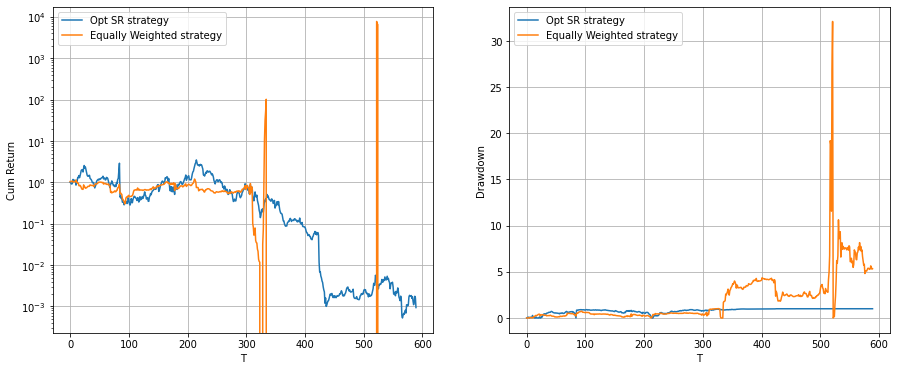

In [11]:
fig, ax = plt.subplots(1, 2, figsize = (15,  6))
cum_ret = metrics.get_cumulativeReturn()

returns[['CumRetSR', 'CumRetEqW']] = cum_ret
returns[['DD_SR', 'DD_EqW']] = metrics.get_drawdown()

ax[0].set_yscale('log')

ax[0].plot(returns['CumRetSR'], label = 'Opt SR strategy')
ax[0].plot(returns['CumRetEqW'], label = 'Equally Weighted strategy')

ax[0].legend()
ax[0].grid()
ax[0].set_ylabel('Cum Return')
ax[0].set_xlabel('T')

ax[1].set_yscale('log')
ax[1].plot(returns['DD_SR'], label = 'Opt SR strategy')
ax[1].plot(returns['DD_EqW'], label = 'Equally Weighted strategy')

ax[1].legend()
ax[1].grid()
ax[1].set_ylabel('Drawdown')
ax[1].set_xlabel('T')

plt.show()

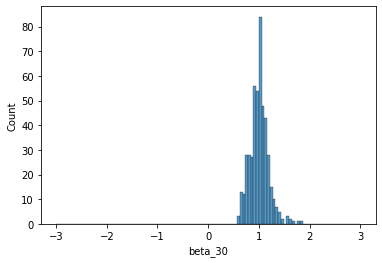

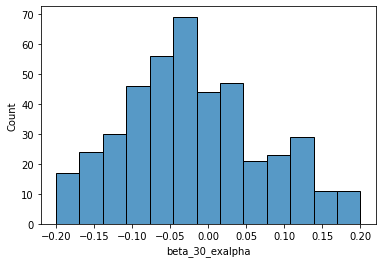

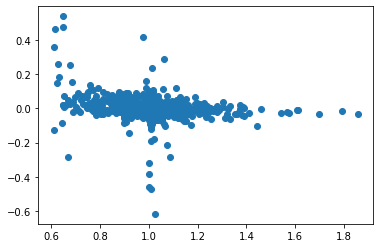

In [9]:
sns.histplot(investableStocks['beta_30'],binrange=(-3,3))
plt.show()
sns.histplot(investableStocks['beta_30_exalpha'],binrange=(-.2,.2))
plt.show()
plt.scatter(investableStocks['beta_30'],investableStocks['scaled_w'])
plt.show()